In [2]:
import sys
sys.path.append('/home/cara/Documents/reddit_analysis_code')
import numpy as np
import pandas as pd
from reddit_dataclass import RedditData as reddit
import pickle
import matplotlib.pyplot as plt
import scipy.stats as scpstat
import matplotlib.dates as dates
import datetime
from sklearn import metrics
import statsmodels.formula.api as smf
import statsmodels.api as sm
from patsy import dmatrices

In [3]:
posts = pickle.load(open('thread_5_posts_EDT_times.p', 'rb'))

In [4]:
thread_info = pickle.load(open('thread_5_info.p', 'rb'))

In [5]:
clean_thread_data = pickle.load(open('clean_5_thread_data.p', 'rb'))

In [6]:
new_posts = {}
for key in posts:
    new_posts[key] = posts[key]['all']

posts = new_posts

In [7]:
for key in thread_info:
    thread_info[key] = thread_info[key][['thread_id', 'thread_size', 'authors']]
thread_info['books']

,thread_id,thread_size,authors
0,xsgu8l,1,1
1,xsh6qv,1,1
2,xshdvl,1,1
3,xsi14p,1,1
4,xsis1h,1,1
...,...,...,...
4771,yhubu4,1,1
4772,yhufba,1,1
4773,yhukih,1,1
4774,yhumfc,1,1


In [8]:
regression_thread_data = {}
for key in thread_info:
    regression_thread_data[key] = pd.merge(
        thread_info[key], 
        posts[key][[
            'thread_id', 'timestamp', 'author', 'score',
            'subject_sentiment_score'
            ]],
        on='thread_id'
    )


# Logistic regression

In [9]:
for key in regression_thread_data:
    regression_thread_data[key]['success'] = 0
    regression_thread_data[key].loc[
        regression_thread_data[key].thread_size > 1, 'success'
    ] = 1

###books###
Optimization terminated successfully.
         Current function value: 0.630529
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                success   No. Observations:                 4776
Model:                          Logit   Df Residuals:                     4774
Method:                           MLE   Df Model:                            1
Date:                Thu, 09 Feb 2023   Pseudo R-squ.:                0.001243
Time:                        12:47:55   Log-Likelihood:                -3011.4
converged:                       True   LL-Null:                       -3015.2
Covariance Type:            nonrobust   LLR p-value:                  0.006193
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -0.7072      0.032    -22.393      0.000   

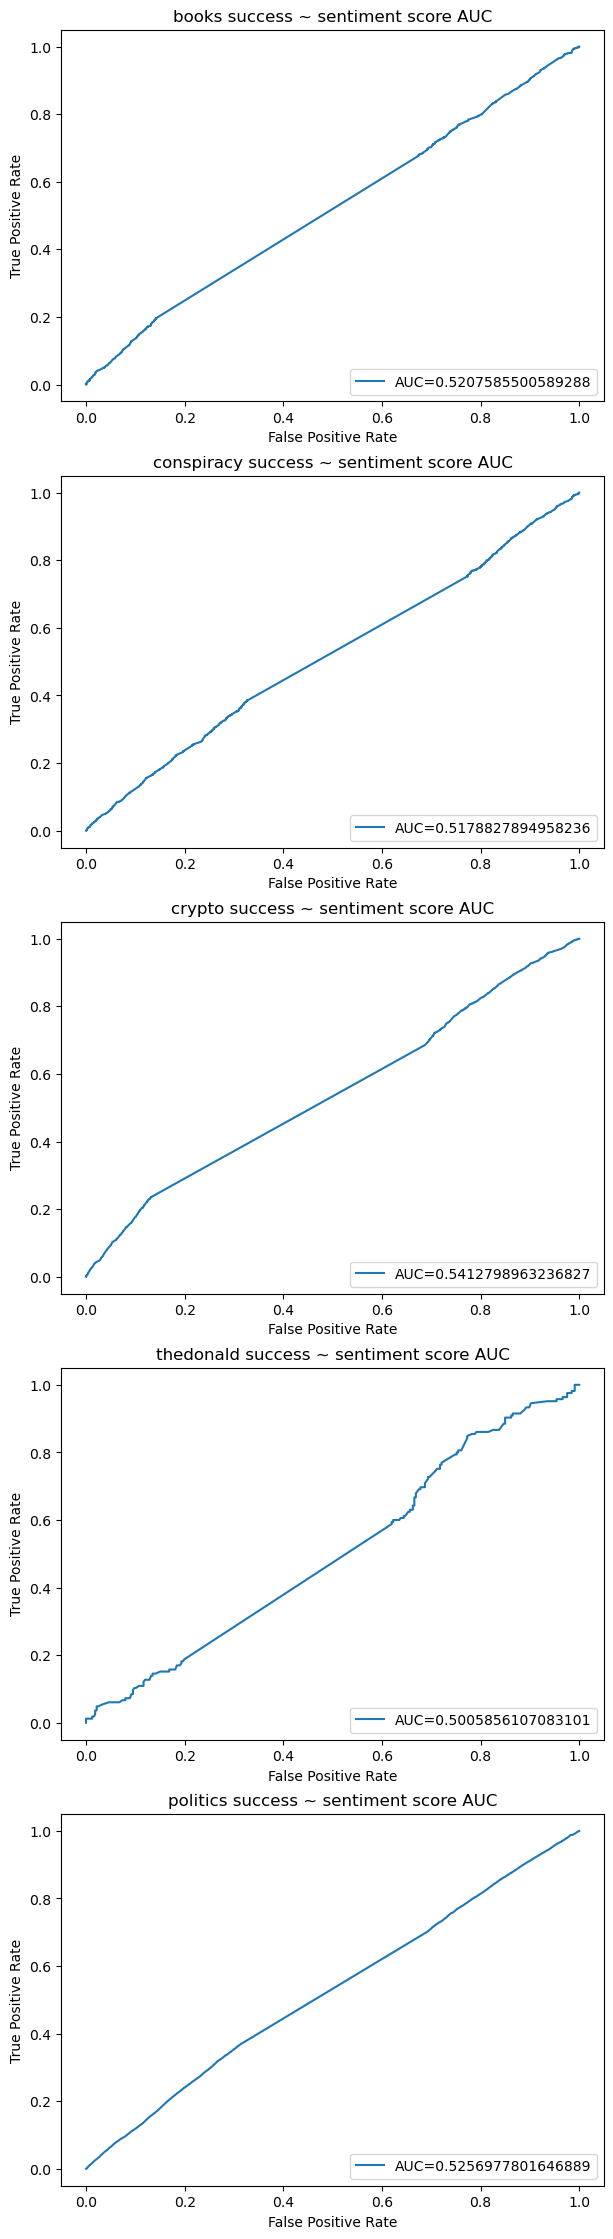

In [10]:
fig, axes = plt.subplots(5, figsize=(7,28))

i = 0

logistic_regression = {}

for key in regression_thread_data:
    print(f'###{key}###')
    logistic_regression[key] = smf.logit(
        "success ~ subject_sentiment_score",
        data=regression_thread_data[key]
    ).fit()
    print(logistic_regression[key].summary())

    y_predicted = logistic_regression[key].predict()
    y_real = regression_thread_data[key].success

    fpr, tpr, _ = metrics.roc_curve(y_real,  y_predicted)
    auc = metrics.roc_auc_score(y_real,  y_predicted)

    axes[i].plot(fpr, tpr, label="AUC="+str(auc))
    axes[i].set_ylabel('True Positive Rate')
    axes[i].set_xlabel('False Positive Rate')
    axes[i].set_title(f"{key} success ~ sentiment score AUC")
    axes[i].legend(loc=4)
    i += 1

plt.show()

    


# Linear regression

In [13]:
thread_size_cols = ['thread_id', 'thread_size', 'authors', 'subject_sentiment_score', 'score']
thread_size_data = {}
for key in regression_thread_data:
    thread_size_data[key] = regression_thread_data[key][thread_size_cols]
    for col in ['thread_size', 'authors', 'score']:
        thread_size_data[key][f'log_{col}'] = np.log(
            thread_size_data[key][col]
            )
    
    


/tmp/ipykernel_49537/2376346354.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_size_data[key][f'log_{col}'] = np.log(
/tmp/ipykernel_49537/2376346354.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_size_data[key][f'log_{col}'] = np.log(
/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_49537/2376346354.py:6: SettingWithCopyW

In [14]:

successful_thread_size_data = {}
for key in thread_size_data:
    successful_thread_size_data[key] = thread_size_data[key][
        thread_size_data[key].thread_size>  1
    ]

## Create design matrices
### For thread size

In [15]:
log_thread_size_X = {}
log_thread_size_y = {}
log_successful_thread_size_X = {}
log_successful_thread_size_y = {}
for key in thread_size_data:
    log_thread_size_y[key], log_thread_size_X[key] = (
        dmatrices(
            'log_thread_size ~ subject_sentiment_score',
            data=thread_size_data[key],
            return_type='dataframe'
        )
    )
    log_successful_thread_size_y[key], log_successful_thread_size_X[key] = (
        dmatrices(
            'log_thread_size ~ subject_sentiment_score',
            data=successful_thread_size_data[key],
            return_type='dataframe'
        )
    )

## OLS regression

In [16]:
thread_size_model = {}
successful_thread_size_model = {}
for key in log_thread_size_X:
    thread_size_model[key] = sm.OLS(log_thread_size_y[key], log_thread_size_X[key]).fit()
    successful_thread_size_model[key] = sm.OLS(log_successful_thread_size_y[key], log_successful_thread_size_X[key]).fit()
    

In [17]:
for key in thread_size_model:
    print(f'###{key}###')
    print('model = ALL, y = thread size, x = subject sentiment score')
    print(thread_size_model[key].summary())
    print('model = SUCCESS ONLY, y = thread size, x = subject sentiment score')
    print(successful_thread_size_model[key].summary())

###books###
model = ALL, y = thread size, x = subject sentiment score
                            OLS Regression Results                            
Dep. Variable:        log_thread_size   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     15.91
Date:                Mon, 06 Feb 2023   Prob (F-statistic):           6.75e-05
Time:                        20:16:53   Log-Likelihood:                -8432.9
No. Observations:                4776   AIC:                         1.687e+04
Df Residuals:                    4774   BIC:                         1.688e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------

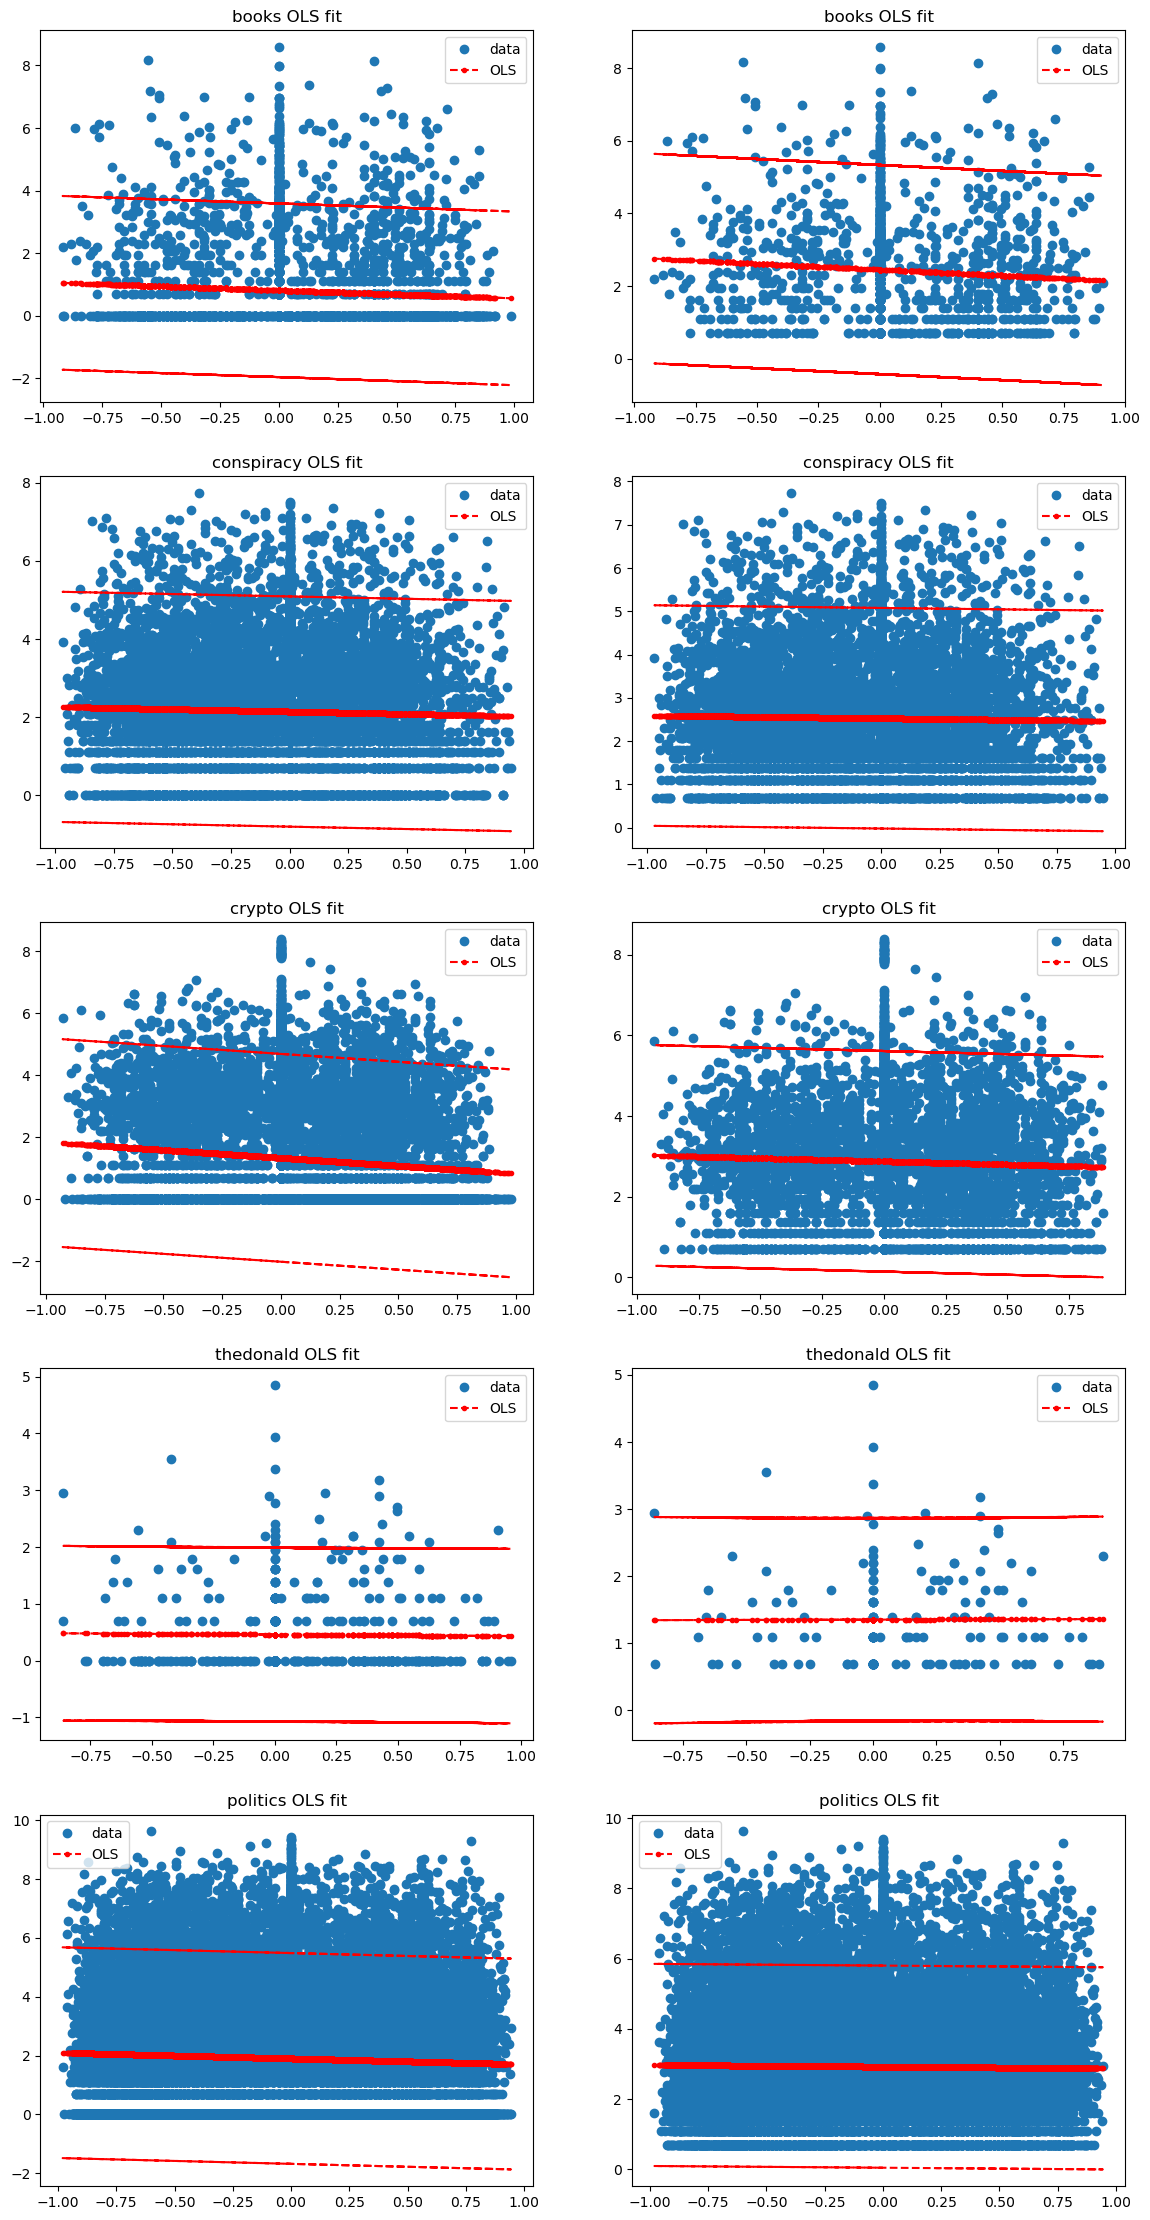

In [18]:
fig, axes = plt.subplots(5,2, figsize=(14, 28))

i = 0

for key in thread_size_model:
    pred_ols = thread_size_model[key].get_prediction()
    # conf intervals
    iv_l = pred_ols.summary_frame()["obs_ci_lower"]
    iv_u = pred_ols.summary_frame()["obs_ci_upper"]
    x = log_thread_size_X[key].subject_sentiment_score
    y = log_thread_size_y[key].log_thread_size
    fitted_vals = thread_size_model[key].fittedvalues

    axes[i, 0].plot(x, y, "o", label="data")
    #axes[i, 0].plot(x, y_true, "b-", label="True")
    axes[i, 0].plot(x, fitted_vals, "r--.", label="OLS")
    axes[i, 0].plot(x, iv_u, "r--")
    axes[i, 0].plot(x, iv_l, "r--")
    axes[i, 0].legend(loc="best")
    axes[i, 0].set_title(f'{key} OLS fit')


    pred_ols = successful_thread_size_model[key].get_prediction()
    iv_l = pred_ols.summary_frame()["obs_ci_lower"]
    iv_u = pred_ols.summary_frame()["obs_ci_upper"]
    x = log_successful_thread_size_X[key].subject_sentiment_score
    y = log_successful_thread_size_y[key].log_thread_size
    fitted_vals = successful_thread_size_model[key].fittedvalues

    axes[i, 1].plot(x, y, "o", label="data")
    #axes[i,1].plot(x, y_true, "b-", label="True")
    axes[i, 1].plot(x, fitted_vals, "r--.", label="OLS")
    axes[i, 1].plot(x, iv_u, "r--")
    axes[i, 1].plot(x, iv_l, "r--")
    axes[i, 1].legend(loc="best")
    axes[i, 1].set_title(f'{key} OLS fit')

    i += 1
plt.show()

## GLS regression

In [19]:
GLS_thread_size_model = {}
GLS_successful_thread_size_model = {}
for key in log_thread_size_X:
    GLS_thread_size_model[key] = sm.GLS(log_thread_size_y[key], log_thread_size_X[key]).fit()
    GLS_successful_thread_size_model[key] = sm.GLS(log_successful_thread_size_y[key], log_successful_thread_size_X[key]).fit()

In [20]:
for key in GLS_thread_size_model:
    print(f'###{key}###')
    print('model = ALL, y = thread size, x = subject sentiment score')
    print(GLS_thread_size_model[key].summary())
    print('model = SUCCESS ONLY, y = thread size, x = subject sentiment score')
    print(GLS_successful_thread_size_model[key].summary())

###books###
model = ALL, y = thread size, x = subject sentiment score
                            GLS Regression Results                            
Dep. Variable:        log_thread_size   R-squared:                       0.003
Model:                            GLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     15.91
Date:                Mon, 06 Feb 2023   Prob (F-statistic):           6.75e-05
Time:                        20:18:24   Log-Likelihood:                -8432.9
No. Observations:                4776   AIC:                         1.687e+04
Df Residuals:                    4774   BIC:                         1.688e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------

# Remove neutrals

In [17]:
non_neutral_regression_thread_data = {}
for key in regression_thread_data:
    non_neutral_regression_thread_data[key] = regression_thread_data[key][regression_thread_data[key].subject_sentiment_score != 0]

In [18]:
for key in non_neutral_regression_thread_data:
    non_neutral_regression_thread_data[key]['success'] = 0
    non_neutral_regression_thread_data[key].loc[
        non_neutral_regression_thread_data[key].thread_size > 1, 'success'
    ] = 1

/tmp/ipykernel_29076/3999846518.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_neutral_regression_thread_data[key]['success'] = 0
/tmp/ipykernel_29076/3999846518.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_neutral_regression_thread_data[key]['success'] = 0
/tmp/ipykernel_29076/3999846518.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

###books###
Optimization terminated successfully.
         Current function value: 0.644212
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                success   No. Observations:                 2316
Model:                          Logit   Df Residuals:                     2314
Method:                           MLE   Df Model:                            1
Date:                Wed, 08 Feb 2023   Pseudo R-squ.:                0.004337
Time:                        16:14:11   Log-Likelihood:                -1492.0
converged:                       True   LL-Null:                       -1498.5
Covariance Type:            nonrobust   LLR p-value:                 0.0003118
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -0.5698      0.046    -12.454      0.000   

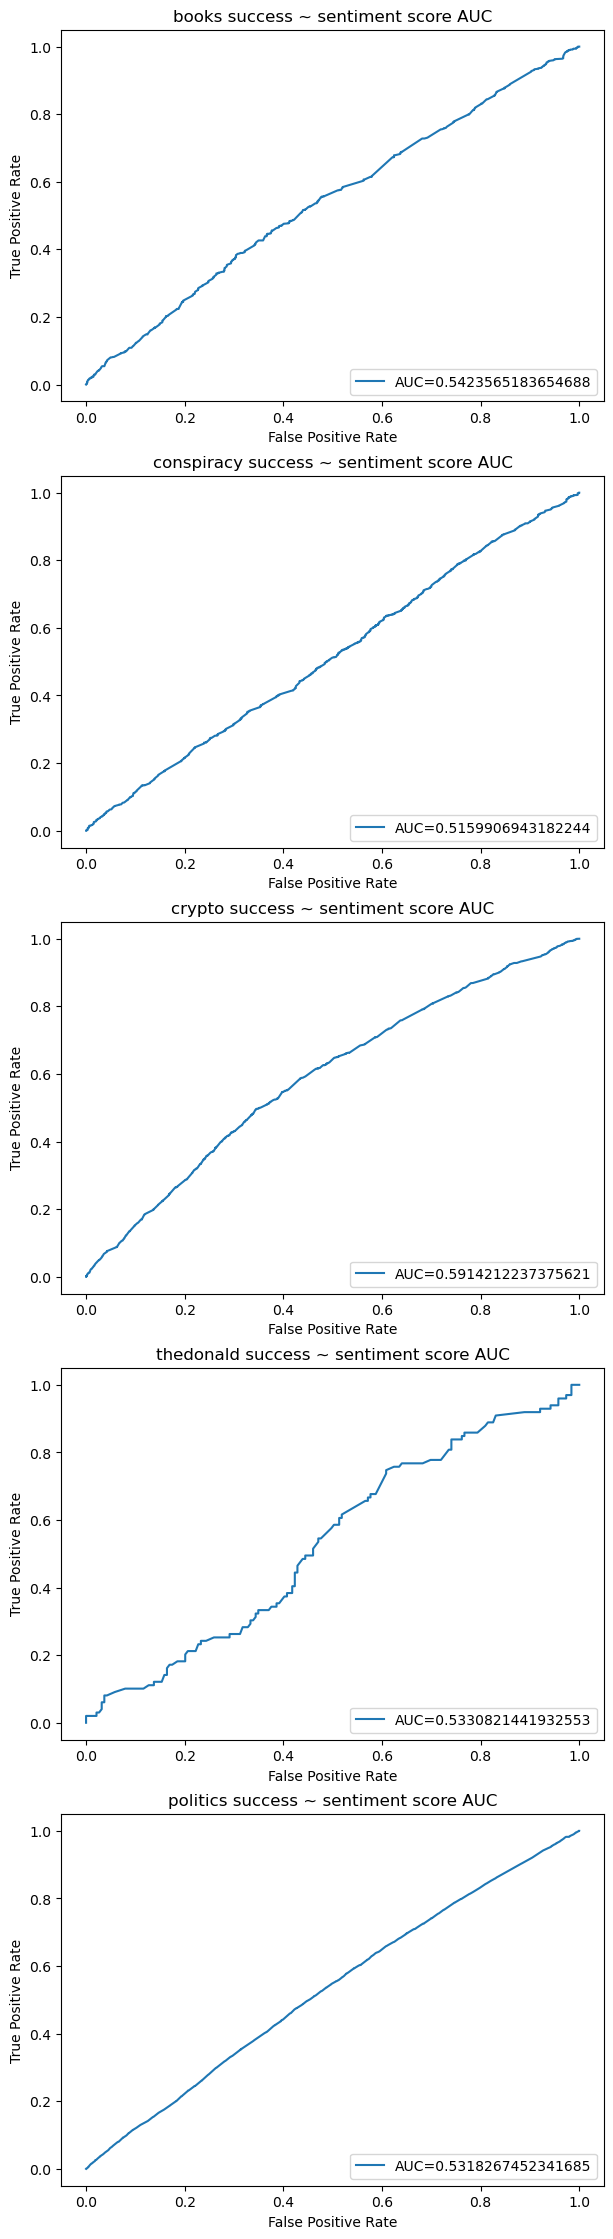

In [20]:
fig, axes = plt.subplots(5, figsize=(7,28))

i = 0

non_neutral_logistic_regression = {}

for key in non_neutral_regression_thread_data:
    print(f'###{key}###')
    non_neutral_logistic_regression[key] = smf.logit(
        "success ~ subject_sentiment_score",
        data=non_neutral_regression_thread_data[key]
    ).fit()
    print(non_neutral_logistic_regression[key].summary())

    y_predicted = non_neutral_logistic_regression[key].predict()
    y_real = non_neutral_regression_thread_data[key].success

    fpr, tpr, _ = metrics.roc_curve(y_real,  y_predicted)
    auc = metrics.roc_auc_score(y_real,  y_predicted)

    axes[i].plot(fpr, tpr, label="AUC="+str(auc))
    axes[i].set_ylabel('True Positive Rate')
    axes[i].set_xlabel('False Positive Rate')
    axes[i].set_title(f"{key} success ~ sentiment score AUC")
    axes[i].legend(loc=4)
    i += 1

plt.show()

In [23]:
thread_size_cols = ['thread_id', 'thread_size', 'authors', 'subject_sentiment_score', 'score']
non_neutral_thread_size_data = {}
for key in non_neutral_regression_thread_data:
    non_neutral_thread_size_data[key] = non_neutral_regression_thread_data[key][thread_size_cols]
    for col in ['thread_size', 'authors', 'score']:
        non_neutral_thread_size_data[key][f'log_{col}'] = np.log(
            non_neutral_thread_size_data[key][col]
            )



non_neutral_successful_thread_size_data = {}
for key in non_neutral_thread_size_data:
    non_neutral_successful_thread_size_data[key] = non_neutral_thread_size_data[key][
        non_neutral_thread_size_data[key].thread_size>  1
    ]


# Create design matrices
log_thread_size_X = {}
log_thread_size_y = {}
log_successful_thread_size_X = {}
log_successful_thread_size_y = {}
for key in non_neutral_thread_size_data:
    log_thread_size_y[key], log_thread_size_X[key] = (
        dmatrices(
            'log_thread_size ~ subject_sentiment_score',
            data=non_neutral_thread_size_data[key],
            return_type='dataframe'
        )
    )
    log_successful_thread_size_y[key], log_successful_thread_size_X[key] = (
        dmatrices(
            'log_thread_size ~ subject_sentiment_score',
            data=non_neutral_successful_thread_size_data[key],
            return_type='dataframe'
        )
    )

#OLS regression
non_neutral_thread_size_model = {}
non_neutral_successful_thread_size_model = {}
for key in log_thread_size_X:
    non_neutral_thread_size_model[key] = sm.OLS(log_thread_size_y[key], log_thread_size_X[key]).fit()
    non_neutral_successful_thread_size_model[key] = sm.OLS(log_successful_thread_size_y[key], log_successful_thread_size_X[key]).fit()

for key in non_neutral_thread_size_model:
    print(f'###{key}###')
    print('model = ALL, y = thread size, x = subject sentiment score')
    print(non_neutral_thread_size_model[key].summary())
    print('model = SUCCESS ONLY, y = thread size, x = subject sentiment score')
    print(non_neutral_successful_thread_size_model[key].summary())
    

/tmp/ipykernel_29076/139431237.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_neutral_thread_size_data[key][f'log_{col}'] = np.log(
/tmp/ipykernel_29076/139431237.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_neutral_thread_size_data[key][f'log_{col}'] = np.log(
/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_29076/139431237.p

###books###
model = ALL, y = thread size, x = subject sentiment score
                            OLS Regression Results                            
Dep. Variable:        log_thread_size   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     22.67
Date:                Wed, 08 Feb 2023   Prob (F-statistic):           2.05e-06
Time:                        16:20:06   Log-Likelihood:                -4189.9
No. Observations:                2316   AIC:                             8384.
Df Residuals:                    2314   BIC:                             8395.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------

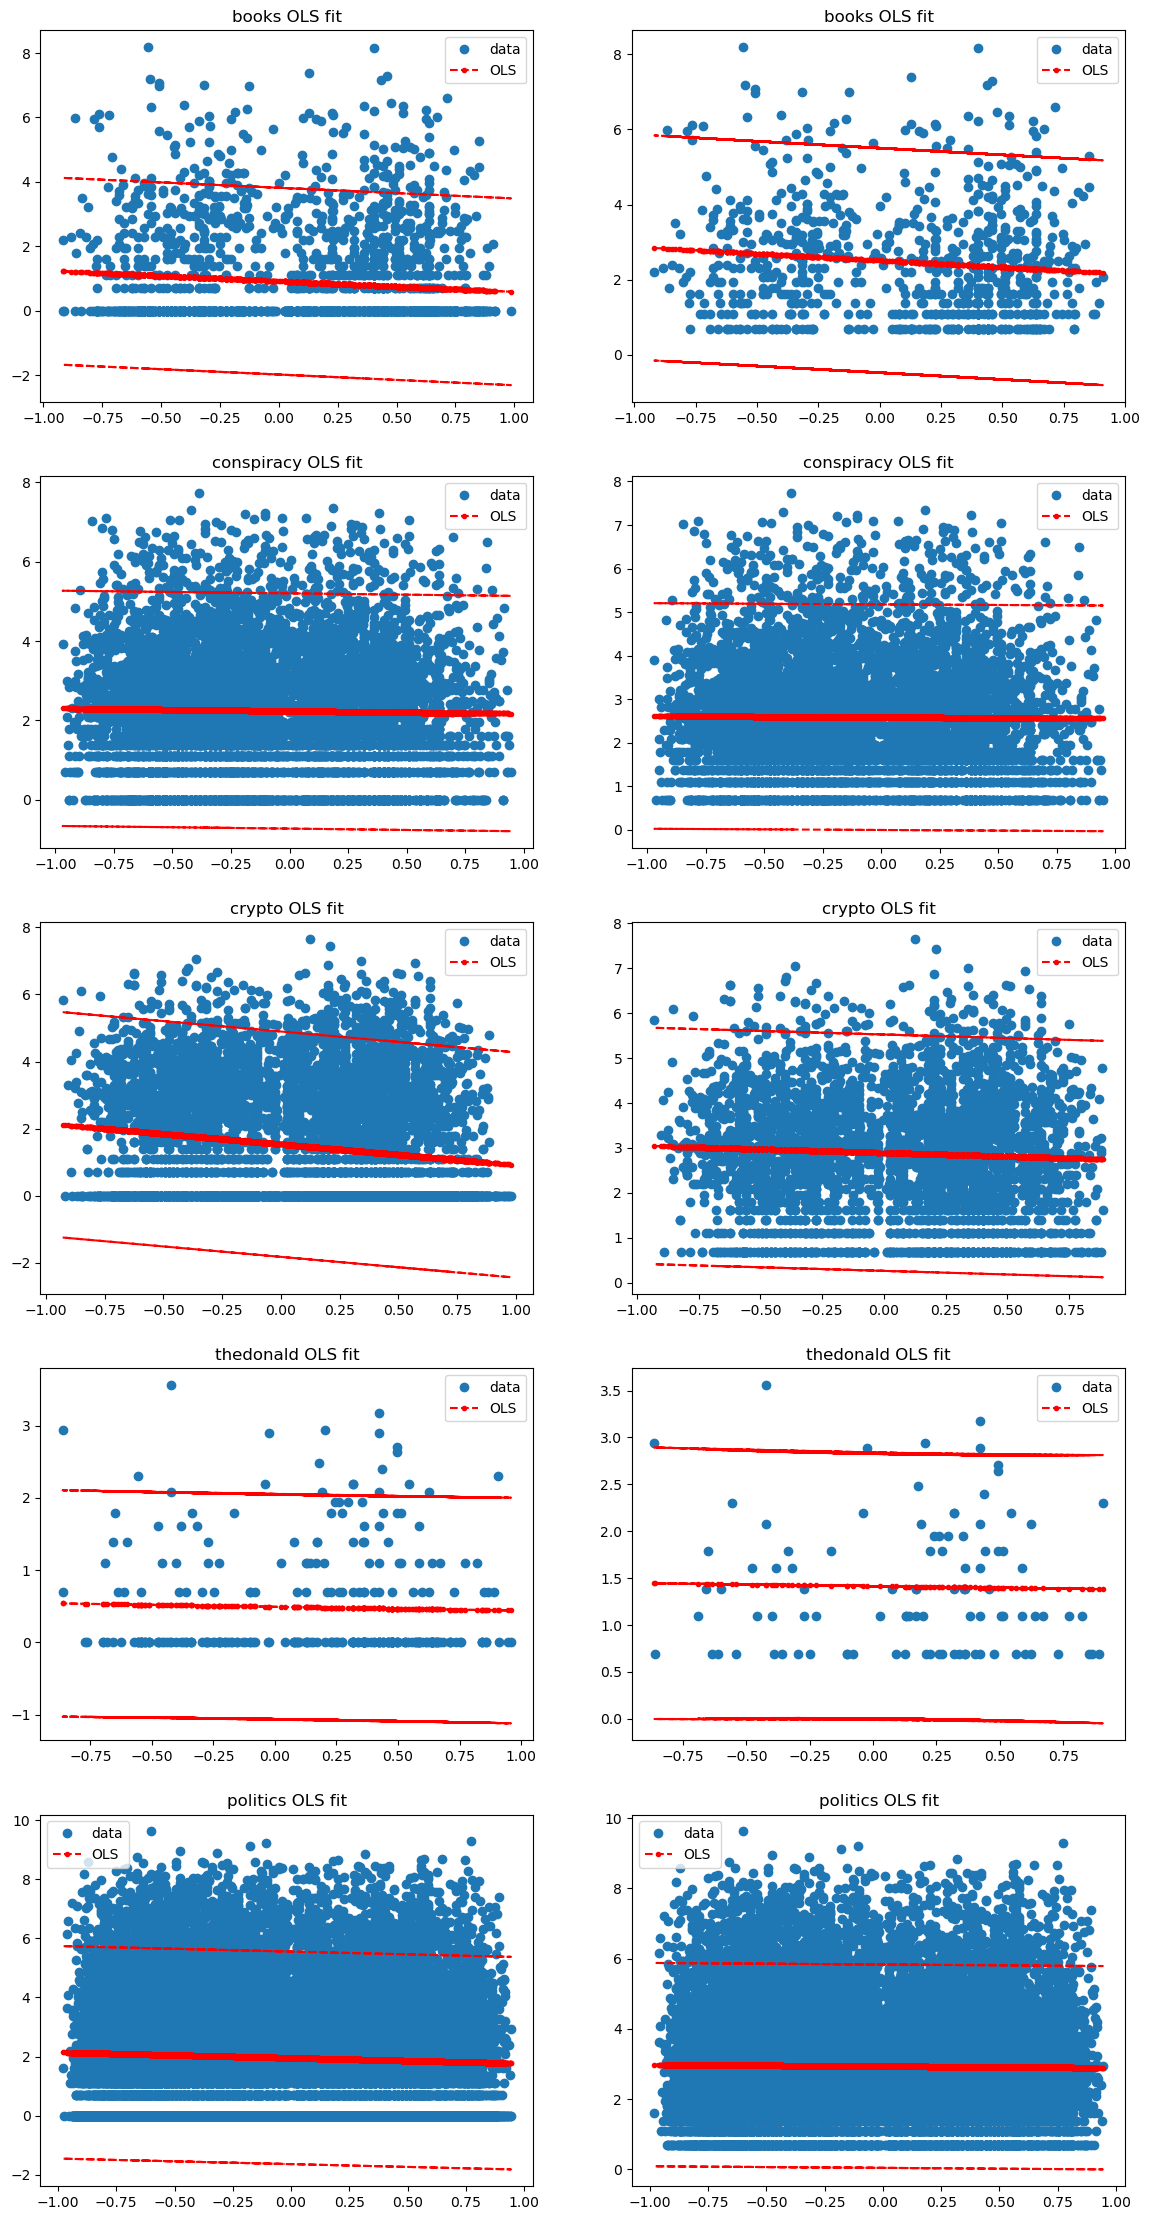

In [24]:
fig, axes = plt.subplots(5,2, figsize=(14, 28))

i = 0

for key in non_neutral_thread_size_model:
    pred_ols = non_neutral_thread_size_model[key].get_prediction()
    # conf intervals
    iv_l = pred_ols.summary_frame()["obs_ci_lower"]
    iv_u = pred_ols.summary_frame()["obs_ci_upper"]
    x = log_thread_size_X[key].subject_sentiment_score
    y = log_thread_size_y[key].log_thread_size
    fitted_vals = non_neutral_thread_size_model[key].fittedvalues

    axes[i, 0].plot(x, y, "o", label="data")
    #axes[i, 0].plot(x, y_true, "b-", label="True")
    axes[i, 0].plot(x, fitted_vals, "r--.", label="OLS")
    axes[i, 0].plot(x, iv_u, "r--")
    axes[i, 0].plot(x, iv_l, "r--")
    axes[i, 0].legend(loc="best")
    axes[i, 0].set_title(f'{key} OLS fit')


    pred_ols = non_neutral_successful_thread_size_model[key].get_prediction()
    iv_l = pred_ols.summary_frame()["obs_ci_lower"]
    iv_u = pred_ols.summary_frame()["obs_ci_upper"]
    x = log_successful_thread_size_X[key].subject_sentiment_score
    y = log_successful_thread_size_y[key].log_thread_size
    fitted_vals = non_neutral_successful_thread_size_model[key].fittedvalues

    axes[i, 1].plot(x, y, "o", label="data")
    #axes[i,1].plot(x, y_true, "b-", label="True")
    axes[i, 1].plot(x, fitted_vals, "r--.", label="OLS")
    axes[i, 1].plot(x, iv_u, "r--")
    axes[i, 1].plot(x, iv_l, "r--")
    axes[i, 1].legend(loc="best")
    axes[i, 1].set_title(f'{key} OLS fit')

    i += 1
plt.show()

In [25]:
# GLS regression
GLS_non_neutral_thread_size_model = {}
GLS_non_neutral_successful_thread_size_model = {}
for key in log_thread_size_X:
    GLS_non_neutral_thread_size_model[key] = sm.GLS(log_thread_size_y[key], log_thread_size_X[key]).fit()
    GLS_non_neutral_successful_thread_size_model[key] = sm.GLS(log_successful_thread_size_y[key], log_successful_thread_size_X[key]).fit()

for key in GLS_non_neutral_thread_size_model:
    print(f'###{key}###')
    print('model = ALL, y = thread size, x = subject sentiment score')
    print(GLS_non_neutral_thread_size_model[key].summary())
    print('model = SUCCESS ONLY, y = thread size, x = subject sentiment score')
    print(GLS_non_neutral_successful_thread_size_model[key].summary())

###books###
model = ALL, y = thread size, x = subject sentiment score
                            GLS Regression Results                            
Dep. Variable:        log_thread_size   R-squared:                       0.010
Model:                            GLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     22.67
Date:                Wed, 08 Feb 2023   Prob (F-statistic):           2.05e-06
Time:                        16:22:33   Log-Likelihood:                -4189.9
No. Observations:                2316   AIC:                             8384.
Df Residuals:                    2314   BIC:                             8395.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------

# separate sign and magnitude

In [39]:

for key in regression_thread_data:
    # get sign
    regression_thread_data[key]['sentiment_sign'] = (
        np.sign(
            regression_thread_data[key].subject_sentiment_score
            )
    )

    # get magnitude
    regression_thread_data[key]['sentiment_magnitude'] = (
        np.abs(
            regression_thread_data[key].subject_sentiment_score
        )
    )


In [12]:
for key in regression_thread_data:
    regression_thread_data[key]['success'] = 0
    regression_thread_data[key].loc[
        regression_thread_data[key].thread_size > 1, 'success'
    ] = 1

In [40]:
#pickle.dump(regression_thread_data, open("regression_thread_data.p", 'wb'))
regression_thread_data = pickle.load(open("regression_thread_data.p", 'rb'))

## Logistic regression

In [41]:
def log_plus_1(x):
    return np.log(x+1)

In [42]:
models = [
    "success ~ sentiment_sign",
    "success ~ sentiment_magnitude",
    "success ~ sentiment_sign + sentiment_magnitude",
    "success ~ sentiment_sign*sentiment_magnitude",
    "success ~ sentiment_sign*sentiment_magnitude + sentiment_sign + sentiment_magnitude"
]

In [43]:
for key in regression_thread_data:
    regression_thread_data[key]['log_sentiment_magnitude_plus_one'] = log_plus_1(regression_thread_data[key].sentiment_magnitude)

In [44]:
models_log = models + [
    "success ~ log_sentiment_magnitude_plus_one",
    "success ~ sentiment_sign + log_sentiment_magnitude_plus_one",
    "success ~ sentiment_sign + sentiment_magnitude + log_sentiment_magnitude_plus_one",
    "success ~ sentiment_sign*log_sentiment_magnitude_plus_one",
    "success ~ sentiment_sign*log_sentiment_magnitude_plus_one + sentiment_sign + log_sentiment_magnitude_plus_one"
]

In [69]:
aucs_tables = {}

In [70]:


aucs = {}
for model in models_log:
    aucs[model] = {}
    for key in regression_thread_data:
        print(key)
        logistic_regression = smf.logit(
            model,
            data=regression_thread_data[key]
        ).fit()
        y_predicted = logistic_regression.predict()
        y_real = regression_thread_data[key].success

        auc = metrics.roc_auc_score(y_real,  y_predicted)
        aucs[model][key] = auc
display(pd.DataFrame.from_dict(aucs, orient='index'))

aucs_tables['all_data'] = pd.DataFrame.from_dict(aucs, orient='index')

"""
for model in models:

    fig, axes = plt.subplots(3,2, figsize=(14,21))

    i = 0
    j = 0

    logistic_regression = {}

    for key in regression_thread_data:
        print(f'###{key}###')
        logistic_regression[key] = smf.logit(
            model,
            data=regression_thread_data[key]
        ).fit()
        #print(logistic_regression[key].summary())

        y_predicted = logistic_regression[key].predict()
        y_real = regression_thread_data[key].success

        fpr, tpr, _ = metrics.roc_curve(y_real,  y_predicted)
        auc = metrics.roc_auc_score(y_real,  y_predicted)

        axes[i,j].plot(fpr, tpr, label="AUC="+str(auc))
        axes[i,j].set_ylabel('True Positive Rate')
        axes[i,j].set_xlabel('False Positive Rate')
        axes[i,j].set_title(f"{key} {model}")
        axes[i,j].legend(loc=4)
        j = (j+1)%2
        if j == 0:
            i += 1
    fig.suptitle(model)
    fig.tight_layout()

    plt.show()
"""

books
Optimization terminated successfully.
         Current function value: 0.630533
         Iterations 5
conspiracy
Optimization terminated successfully.
         Current function value: 0.424192
         Iterations 6
crypto
Optimization terminated successfully.
         Current function value: 0.686714
         Iterations 4
thedonald
Optimization terminated successfully.
         Current function value: 0.637998
         Iterations 4
politics
Optimization terminated successfully.
         Current function value: 0.645007
         Iterations 4
books
Optimization terminated successfully.
         Current function value: 0.630782
         Iterations 5
conspiracy
Optimization terminated successfully.
         Current function value: 0.423563
         Iterations 6
crypto
Optimization terminated successfully.
         Current function value: 0.687770
         Iterations 4
thedonald
Optimization terminated successfully.
         Current function value: 0.638194
         Iterations 4
polit

,books,conspiracy,crypto,thedonald,politics
success ~ sentiment_sign,0.519496,0.515527,0.534840,0.516276,0.522197
success ~ sentiment_magnitude,0.522866,0.536628,0.543428,0.509453,0.520733
success ~ sentiment_sign + sentiment_magnitude,0.523202,0.535417,0.529186,0.558161,0.523446
success ~ sentiment_sign*sentiment_magnitude,0.526071,0.536029,0.572484,0.546728,0.533987
success ~ sentiment_sign*sentiment_magnitude + sentiment_sign + sentiment_magnitude,0.526071,0.536029,0.572484,0.546728,0.533987
success ~ log_sentiment_magnitude_plus_one,0.522866,0.536628,0.543428,0.509453,0.520733
success ~ sentiment_sign + log_sentiment_magnitude_plus_one,0.529496,0.534844,0.535186,0.556934,0.525144
success ~ sentiment_sign + sentiment_magnitude + log_sentiment_magnitude_plus_one,0.528734,0.535319,0.557134,0.545278,0.530191
success ~ sentiment_sign*log_sentiment_magnitude_plus_one,0.528403,0.536190,0.572297,0.561024,0.535680
success ~ sentiment_sign*log_sentiment_magnitude_plus_one + sentiment_sign + log_sentiment_magnitude_plus_one,0.528403,0.536190,0.572297,0.561024,0.535680


'\nfor model in models:\n\n    fig, axes = plt.subplots(3,2, figsize=(14,21))\n\n    i = 0\n    j = 0\n\n    logistic_regression = {}\n\n    for key in regression_thread_data:\n        print(f\'###{key}###\')\n        logistic_regression[key] = smf.logit(\n            model,\n            data=regression_thread_data[key]\n        ).fit()\n        #print(logistic_regression[key].summary())\n\n        y_predicted = logistic_regression[key].predict()\n        y_real = regression_thread_data[key].success\n\n        fpr, tpr, _ = metrics.roc_curve(y_real,  y_predicted)\n        auc = metrics.roc_auc_score(y_real,  y_predicted)\n\n        axes[i,j].plot(fpr, tpr, label="AUC="+str(auc))\n        axes[i,j].set_ylabel(\'True Positive Rate\')\n        axes[i,j].set_xlabel(\'False Positive Rate\')\n        axes[i,j].set_title(f"{key} {model}")\n        axes[i,j].legend(loc=4)\n        j = (j+1)%2\n        if j == 0:\n            i += 1\n    fig.suptitle(model)\n    fig.tight_layout()\n\n    plt.sh

In [71]:
aucs = {}
for model in models_log:
    aucs[model] = {}
    for key in regression_thread_data:
        non_neutral_regression_thread_data = regression_thread_data[key][regression_thread_data[key].sentiment_sign != 0]
        logistic_regression = smf.logit(
            model,
            data=non_neutral_regression_thread_data
        ).fit()
        y_predicted = logistic_regression.predict()
        y_real = non_neutral_regression_thread_data.success

        auc = metrics.roc_auc_score(y_real,  y_predicted)
        aucs[model][key] = auc
pd.DataFrame.from_dict(aucs, orient='index').style.set_caption('neutral sentiment posts excluded')
aucs_tables['neutrals_excluded'] = pd.DataFrame.from_dict(aucs, orient='index')

Optimization terminated successfully.
         Current function value: 0.644205
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.395411
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683691
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.643008
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.634551
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.646828
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.395480
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.690956
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.640747
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635535
  

In [70]:
"""
for model in models:

    fig, axes = plt.subplots(3,2, figsize=(14,21))

    i = 0
    j = 0

    logistic_regression = {}

    for key in regression_thread_data:
        non_neutral_regression_thread_data = regression_thread_data[key][regression_thread_data[key].sentiment_sign != 0]
        print(f'###{key}###')
        logistic_regression[key] = smf.logit(
            model,
            data=non_neutral_regression_thread_data
        ).fit()
        #print(logistic_regression[key].summary())

        y_predicted = logistic_regression[key].predict()
        y_real = non_neutral_regression_thread_data.success

        fpr, tpr, _ = metrics.roc_curve(y_real,  y_predicted)
        auc = metrics.roc_auc_score(y_real,  y_predicted)

        axes[i,j].plot(fpr, tpr, label="AUC="+str(auc))
        axes[i,j].set_ylabel('True Positive Rate')
        axes[i,j].set_xlabel('False Positive Rate')
        axes[i,j].set_title(f"{key} {model}")
        axes[i,j].legend(loc=4)
        j = (j+1)%2
        if j == 0:
            i += 1
    fig.suptitle(f"{model} (non neutrals)")
    fig.tight_layout()

    plt.show()
    """

'\nfor model in models:\n\n    fig, axes = plt.subplots(3,2, figsize=(14,21))\n\n    i = 0\n    j = 0\n\n    logistic_regression = {}\n\n    for key in regression_thread_data:\n        non_neutral_regression_thread_data = regression_thread_data[key][regression_thread_data[key].sentiment_sign != 0]\n        print(f\'###{key}###\')\n        logistic_regression[key] = smf.logit(\n            model,\n            data=non_neutral_regression_thread_data\n        ).fit()\n        #print(logistic_regression[key].summary())\n\n        y_predicted = logistic_regression[key].predict()\n        y_real = non_neutral_regression_thread_data.success\n\n        fpr, tpr, _ = metrics.roc_curve(y_real,  y_predicted)\n        auc = metrics.roc_auc_score(y_real,  y_predicted)\n\n        axes[i,j].plot(fpr, tpr, label="AUC="+str(auc))\n        axes[i,j].set_ylabel(\'True Positive Rate\')\n        axes[i,j].set_xlabel(\'False Positive Rate\')\n        axes[i,j].set_title(f"{key} {model}")\n        axes[i,j].

# Only frequent-posted authors?

In [47]:
author_counts = {}
for key in regression_thread_data:
    author_counts[key] = (
        regression_thread_data[key][['thread_id', 'author']]
        .groupby('author').count().reset_index()
        .rename(columns={'thread_id': 'post_count'})
    )

In [48]:
post_count_thresholds = [2, 5, 10, 20]

In [80]:
aucs = {}
for model in models_log:
    aucs[model] = {}
    for key in regression_thread_data:
        aucs[model][key] = {}

        for threshold in post_count_thresholds:

            authors = author_counts[key][author_counts[key].post_count >= threshold].author
            threshold_regression_data = regression_thread_data[key][regression_thread_data[key].author.isin(authors)]
            logistic_regression = {}
            logistic_regression[key] = smf.logit(
                model,
                data=threshold_regression_data
            ).fit()

            y_predicted = logistic_regression[key].predict()
            y_real = threshold_regression_data.success

            auc = metrics.roc_auc_score(y_real,  y_predicted)

            aucs[model][key][threshold] = auc


Optimization terminated successfully.
         Current function value: 0.582520
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568834
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630616
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.533053
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.389199
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351858
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.349453
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.336107
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685627
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.606898
  

In [72]:
model_numbers = [x for x in range(0, len(models_log))]
model_mapper = dict(zip(models_log, model_numbers))


In [73]:
models_df = pd.DataFrame(data=models_log, columns=['keys'])

In [79]:
aucs_tables.keys()

dict_keys(['all_data', 'neutrals_excluded', 'models_key'])

In [76]:
aucs_tables['models_key'] = models_df

In [81]:
for model in aucs:
    display(pd.DataFrame.from_dict(aucs[model]).style.set_caption(model))
    aucs_tables[f'threshold_mod{model_mapper[model]}'] = pd.DataFrame.from_dict(aucs[model])
#pd.DataFrame.from_dict(aucs['success ~ sentiment_sign'])

,books,conspiracy,crypto,thedonald,politics
2,0.506439,0.509409,0.534920,0.514189,0.514086
5,0.502413,0.524885,0.531500,0.514740,0.509052
10,0.545674,0.537682,0.520710,0.491754,0.508186
20,0.538704,0.558937,0.511901,0.523117,0.510012


,books,conspiracy,crypto,thedonald,politics
2,0.532436,0.542011,0.540486,0.498142,0.512488
5,0.533861,0.538909,0.523469,0.502588,0.506815
10,0.506036,0.535172,0.524941,0.504425,0.501153
20,0.583142,0.521636,0.531580,0.528701,0.501802


,books,conspiracy,crypto,thedonald,politics
2,0.530092,0.542036,0.526926,0.548944,0.512003
5,0.514555,0.527675,0.523016,0.559390,0.506318
10,0.553119,0.533882,0.521580,0.489340,0.509198
20,0.581709,0.554467,0.526733,0.532078,0.511960


,books,conspiracy,crypto,thedonald,politics
2,0.529442,0.535749,0.567974,0.521410,0.521719
5,0.539291,0.547116,0.545847,0.537389,0.513789
10,0.553119,0.532540,0.536901,0.548270,0.510082
20,0.582856,0.572431,0.531003,0.567662,0.511157


,books,conspiracy,crypto,thedonald,politics
2,0.529442,0.535749,0.567974,0.521410,0.521719
5,0.539291,0.547116,0.545847,0.537389,0.513789
10,0.553119,0.532540,0.536901,0.548270,0.510082
20,0.582856,0.572431,0.531003,0.567662,0.511157


,books,conspiracy,crypto,thedonald,politics
2,0.532436,0.542011,0.540486,0.498142,0.512488
5,0.533861,0.538909,0.523469,0.502588,0.506815
10,0.506036,0.535172,0.524941,0.504425,0.501153
20,0.583142,0.521636,0.531580,0.528701,0.501802


,books,conspiracy,crypto,thedonald,politics
2,0.531475,0.541929,0.531347,0.546917,0.514535
5,0.516290,0.532809,0.519060,0.563129,0.505106
10,0.553119,0.531135,0.522854,0.489944,0.507173
20,0.580849,0.554467,0.526011,0.530000,0.512053


,books,conspiracy,crypto,thedonald,politics
2,0.539496,0.541988,0.557776,0.539147,0.521996
5,0.575641,0.544923,0.545132,0.573483,0.514600
10,0.595573,0.553443,0.531373,0.522727,0.508878
20,0.634461,0.551449,0.530169,0.529221,0.508879


,books,conspiracy,crypto,thedonald,politics
2,0.533138,0.535125,0.569545,0.520735,0.523053
5,0.540649,0.547225,0.548345,0.534800,0.514500
10,0.547485,0.530090,0.537512,0.550080,0.509856
20,0.581995,0.572647,0.532432,0.572597,0.510922


,books,conspiracy,crypto,thedonald,politics
2,0.533138,0.535125,0.569545,0.520735,0.523053
5,0.540649,0.547225,0.548345,0.534800,0.514500
10,0.547485,0.530090,0.537512,0.550080,0.509856
20,0.581995,0.572647,0.532432,0.572597,0.510922


In [82]:
aucs_tables.keys()

dict_keys(['all_data', 'neutrals_excluded', 'models_key', 'threshold_mod0', 'threshold_mod1', 'threshold_mod2', 'threshold_mod3', 'threshold_mod4', 'threshold_mod5', 'threshold_mod6', 'threshold_mod7', 'threshold_mod8', 'threshold_mod9'])

In [83]:
with pd.ExcelWriter('logit_regression_tables.xlsx', engine='xlsxwriter') as writer:
    for key in aucs_tables:
        aucs_tables[key].to_excel(writer, sheet_name=key)